# Kaggle - Titanic ML Testing - July 2017

## Prep

In [1]:
import numpy as np
import pandas as pd
import re 
import os
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

# Basis: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print(os.getcwd())
os.chdir('/Users/rjf/Desktop/projects/kaggle/tuts/titanic/data/')
print(os.getcwd())

# Load train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

/Users/rjf
/Users/rjf/Desktop/projects/kaggle/tuts/titanic/data


In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering

Citing "Sina" for "full_data" idea for mapping datasets to full numeric values.

In [4]:
# NaN in Sex
test['Sex'].value_counts(dropna=False)

male      266
female    152
Name: Sex, dtype: int64

In [5]:
all_data = [train, test]

In [6]:
# Feature identifying whether or not a passenger has a cabin assigned on the titanic (dummy variable)
for dataset in all_data:
    dataset['hasCabin'] = dataset['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

In [7]:
#test.head(5)
train['Age'].value_counts(dropna=False)

NaN       177
 24.00     30
 22.00     27
 18.00     26
 28.00     25
 19.00     25
 30.00     25
 21.00     24
 25.00     23
 36.00     22
 29.00     20
 32.00     18
 26.00     18
 35.00     18
 27.00     18
 16.00     17
 31.00     17
 34.00     15
 23.00     15
 33.00     15
 20.00     15
 39.00     14
 17.00     13
 42.00     13
 40.00     13
 45.00     12
 38.00     11
 50.00     10
 2.00      10
 4.00      10
         ... 
 28.50      2
 63.00      2
 0.83       2
 30.50      2
 70.00      2
 57.00      2
 0.75       2
 13.00      2
 59.00      2
 10.00      2
 64.00      2
 40.50      2
 45.50      2
 32.50      2
 20.50      1
 24.50      1
 0.67       1
 70.50      1
 0.92       1
 74.00      1
 34.50      1
 14.50      1
 80.00      1
 12.00      1
 53.00      1
 36.50      1
 55.50      1
 66.00      1
 23.50      1
 0.42       1
Name: Age, Length: 89, dtype: int64

In [8]:
for dataset in all_data:
    # Add feature familySize = Siblings + Parch + 1 (for the passenger)
    dataset['familySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    # Add feature isAlone from familySize reflecting if a passenger is traveling w/o family (0/1 indicator)
    dataset['isAlone'] = 0
    dataset.loc[dataset['familySize'] == 1, 'isAlone'] = 1
    
    # Remove NULLS from the embarked col
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    # Replace NULLS from the Fare col with median value of Fare in the training data (to avoid look-ahead bias)
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
    # Add feature fareQuartile to capture quartile of distribution of fares in which each passengers fare is
    # again using the training data to avoid look-ahed bias
    #dataset['fareQuartile'] = pd.cut(train['Fare'], 4)
    
    # Randomly assign NaNs on Age to other categories used later
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    # for EDA only: train['ageQuintile'] = pd.cut(train['Age'], 5)
    
    # Skipping the title thing
    
    # Encode cats as floats
    
    # Map sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Map embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Map fare (why???)
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Map age (why???)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [9]:
#print(train['isAlone'].value_counts(dropna=False))
#print(train['familySize'].value_counts(dropna=False))
#print(train['Age'].value_counts(dropna=False))
print(train['Age'].value_counts(dropna=False))
#print(train['Sex'].value_counts(dropna=False))

1    446
2    251
0    114
3     69
4     11
Name: Age, dtype: int64


In [10]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasCabin,familySize,isAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,0,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,1,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,0,1,1


In [11]:
test.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,hasCabin,familySize,isAlone
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.636364,1.373206,0.447368,0.392344,1.485646,0.464115,0.217703,1.839713,0.605263
std,120.810458,0.841838,0.481622,0.780119,0.896760,0.981429,1.148885,0.685516,0.413179,1.519072,0.489380
min,892.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,996.250000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1100.500000,3.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000
75%,1204.750000,3.000000,1.000000,2.000000,1.000000,0.000000,3.000000,1.000000,0.000000,2.000000,1.000000
max,1309.000000,3.000000,1.000000,4.000000,8.000000,9.000000,3.000000,2.000000,1.000000,11.000000,1.000000


## Extract Features

Now we limit our data for the ML pipeline to numeric values only, as that's all that the algos we're using can parse.

In [12]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
#train = train.drop(['ageQuintile', 'fareQuartile'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [13]:
# WARN: AGE has a Null - where originated in sequence of cells?
#test.isnull()
#test.head(30)
print(train['Age'].value_counts(dropna=False))
print(train['Parch'].value_counts(dropna=False))
print(train['Fare'].value_counts(dropna=False))
print(train['Embarked'].value_counts(dropna=False))

1    446
2    251
0    114
3     69
4     11
Name: Age, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
2    229
0    223
3    222
1    217
Name: Fare, dtype: int64
0    646
1    168
2     77
Name: Embarked, dtype: int64


## Visualizations

### Correlation Plots (Seaborn)

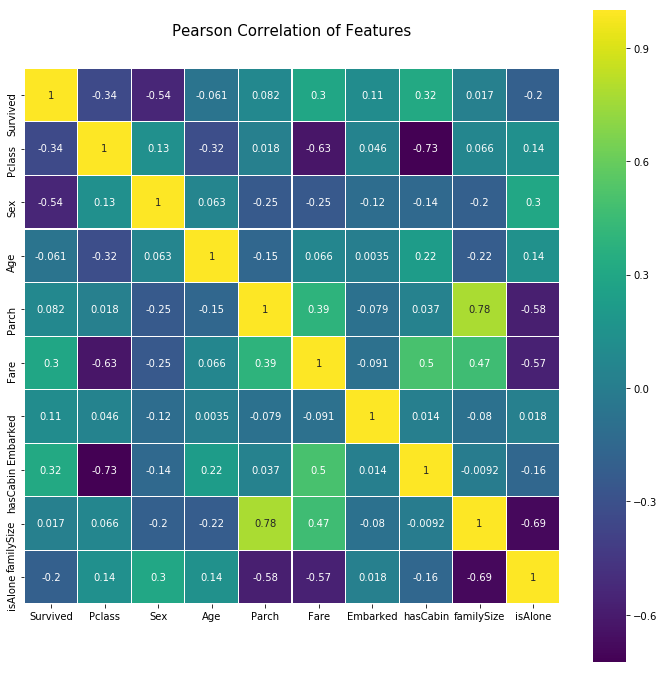

In [14]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Pairplots (seaborn)

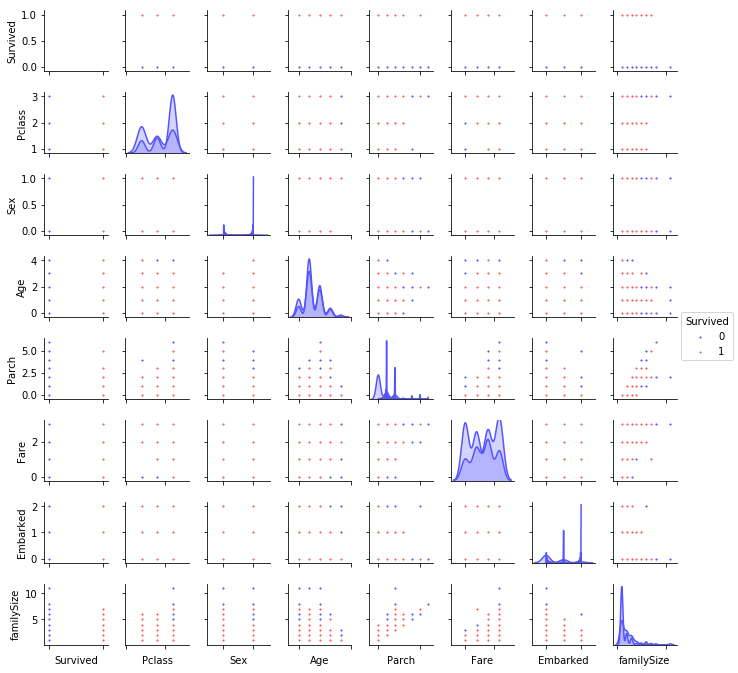

In [15]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'familySize']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

## Ensembling and Stacking ML Models

First, we use OOP principles to create an skLearnHelper class that lets us abstract over commonalities in method invocation to avoid explicitly calling the same methods for each of the 5 classifiers / learners used in the ensemble.

These commonalities include the methods train, predict, fit, and feature importances.

In [16]:
# Parms for later
nTrain = train.shape[0]
nTest = test.shape[0]
seedSetting = 0 # for reproducibility
nFolds = 5 # set folds for out-of-fold prediction
kf = KFold(nTrain, n_folds= nFolds, random_state=seedSetting)

# Writing the class
''' def init : Python standard for invoking the default constructor for the class. 
This means that when you want to create an object (classifier), 
you have to give it the parameters of clf (what sklearn classifier you want), 
seed (random seed) and params (parameters for the classifiers). The rest of the code
consists of class methods calling the corresponding methods built-in to the sklearn 
classifiers.
'''
class skLearnHelper(object):
    
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fix(x, y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    


In [17]:
# Next, we create a function to get out-of-fold (oof) predictions to avoid look-ahead bias:

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((nTrain,))
    oof_test = np.zeros((nTest,))
    oof_test_skf = np.empty((nFolds, nTest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [18]:
# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

'''
Currently using ALL Models
Random Forest classifier
Extra Trees classifier
AdaBoost classifer
Gradient Boosting classifer (x)
Support Vector Machine
'''

In [19]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [20]:
# Create 5 objects that represent our 4 models
rf = skLearnHelper(clf=RandomForestClassifier, seed=seedSetting, params=rf_params)
et = skLearnHelper(clf=ExtraTreesClassifier, seed=seedSetting, params=et_params)
ada = skLearnHelper(clf=AdaBoostClassifier, seed=seedSetting, params=ada_params)
gb = skLearnHelper(clf=GradientBoostingClassifier, seed=seedSetting, params=gb_params)
svc = skLearnHelper(clf=SVC, seed=seedSetting, params=svc_params)

In [21]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [22]:
#y_train.dtype
#x_test.dtype
#test.head(3)
#x_train = x_train.astype(np.float32, copy=False)
#x_test = x_test.astype(np.float32, copy=False)
#y_train = y_train.astype(np.float32, copy=False)

In [23]:
print(x_test)

[[3 1 2 ..., 0 1 1]
 [3 0 2 ..., 0 2 0]
 [2 1 3 ..., 0 1 1]
 ..., 
 [3 1 2 ..., 0 1 1]
 [3 1 1 ..., 0 1 1]
 [3 1 1 ..., 0 3 0]]


In [24]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [25]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.15051183  0.41852206  0.06228704  0.03143701  0.10972482  0.03324915
  0.08868795  0.08137945  0.02420069]
[ 0.13762303  0.51507379  0.05277944  0.021128    0.07241362  0.03308771
  0.09379893  0.04994714  0.02414832]
[ 0.05   0.022  0.028  0.632  0.034  0.022  0.006  0.188  0.018]
[ 0.122772    0.12736519  0.15422036  0.07604414  0.15576653  0.13427711
  0.04748163  0.1469559   0.03511714]


In [26]:
rf_features = [ 0.15450665,  0.41986354,  0.05775269,  
                0.03233478,  0.10867906,  0.03344223,
                0.08985671,  0.08006219,  0.02350214]

et_features = [ 0.1400065,   0.5192765,   0.04707642,
                0.02229567,  0.07034579,  0.03299437,
                0.09442415,  0.05003714,  0.02354346]

ada_features = [ 0.052,  0.02,   0.036,
                 0.622,  0.024,  0.022,
                 0.008,  0.208,  0.008]

gb_features = [ 0.13017356,  0.12740331,  0.13950974,
                0.08228683,  0.15782127,  0.11708483,
                0.04351457,  0.16042706,  0.04177881]

In [27]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [28]:
# Load in our libraries

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [29]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [30]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(10)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.052,0.140007,0.130174,0.154507,Pclass,0.119172
1,0.020,0.519277,0.127403,0.419864,Sex,0.271636
2,0.036,0.047076,0.139510,0.057753,Age,0.070085
3,0.622,0.022296,0.082287,0.032335,Parch,0.189729
4,0.024,0.070346,0.157821,0.108679,Fare,0.090212
5,0.022,0.032994,0.117085,0.033442,Embarked,0.051380
6,0.008,0.094424,0.043515,0.089857,hasCabin,0.058949
7,0.208,0.050037,0.160427,0.080062,familySize,0.124632
8,0.008,0.023543,0.041779,0.023502,isAlone,0.024206


In [31]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [32]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [33]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [34]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

## Second Level Model - XG Boost

This is the final pre-submission step of fitting XG Boost to the first level training and target datasets and generating out predictions. XG Boost is a powerful boosted tree learner.

In [36]:
gbm = xgb.XGBClassifier(
    # default learning_rate = 0.02,
    n_estimators = 200,
    max_depth = 4,
    min_child_weight = 2,
    # default gamma = 1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1, #use all threads available
    scale_pos_weight = 1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

In [38]:
PassengerId.head(5)

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

In [39]:
# Generate submission file
stackSub = pd.DataFrame({'PassengerId' : PassengerId, 'Survived' : predictions})
stackSub.to_csv('stackSub.csv', index=False)